# Assignment: 2D radioactive lighthouse location using MCMC

As before, a radioactive source that emits gamma rays randomly in time but uniformly in angle is placed at $(x_0, y_0)$.  The gamma rays are detected on the $x$-axis and these positions are saved, $x_k$, $k=1,2,\cdots, N$.  Given these observed positions, the problem is to estimate the location of the source.

Unlike before, we will not assume that $y_0$ is known. Your task is to estimate both $x_0$ and $y_0$.  Since we are using Bayesian methods, this means finding the joint posterior for $x_0$ and $y_0$, given the data on where the gamma rays were detected.

You will combine the results and Python code from the `radioactive_lighthouse_exercise.ipynb` and `parameter_estimation_Gaussian_noise.ipynb` notebooks, sampling the posterior using `emcee` and plotting it using `corner`.


## Learning goals:

* Be able to re-use markdown and Python from existing notebooks to perform similar tasks (even if not understanding all details); e.g., generating data, sampling via MCMC, making plots.
* Successfully apply the basic ideas of Bayesian statistics: Bayes theorem, priors, sampling of posteriors.
* Successfully analyze results (with hints).
* Try out markdown.

Note: you shouldn't need to recalculate anything; focus on the notebook ingredients.

## Expressions

The posterior we want is:

$$ p(x_0, y_0 | \{x_k\}, I) = \frac{p(\{x_k\} | x_0,y_0,I)p(x_0,y_0 | I)}{p(\{x_k\} | I)} \propto p(\{x_k\} | x_0,y_0,I)p(x_0,y_0 | I)$$

The final expression will be the expression we work with, treating the denominator as the normalization factor.

*Using $\LaTeX$, fill in the right side of the equation for Bayes' rule as it applies in this case.* 


*Then add below the expression for the likelihood in this case (replace the dots with the correct form and fill in the right side):*

$$  p(\{x_k\} | x_0,y_0,I) = \prod_kp(x_k | x_0,y_0,I) = \frac{1}{\pi}\prod_k\frac{\partial}{\partial x_k}\tan^{-1}\left(\frac{x_k-x_0}{y_0}\right) = \frac{y_0}{\pi}\prod_k\left[\frac{1}{y_0^2+(x_k-x_0)^2}\right]$$


*Describe in words what you will use for the prior:*

I will use uniform distribution for $-5\leq x_0\leq 5$ and $0\leq y_0 \leq 10$, as we only know that $y_0$ is positive. The uniform distribution allows for equal weights at each possible position.

*Do you need to find an expression for the denominator pdf?  Explain.*

No, as mentioned before, the denominator pdf is merely a normalization factor for the joint posterior pdf because the denominator pdf is independent of $x_0$ or $y_0$.

## Python imports

You will need to import emcee and corner.  The best way to do this is to follow the instructions for making an environment (see Carmen page).  An alternative is to install them separately using (at the command line):

`conda install -c astropy emcee`

`conda install -c astropy corner`

In [2]:
# Copy to here all of the Python imports you think will be relevant
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy.stats as stats
from scipy.stats import cauchy, uniform
import seaborn as sns; sns.set()

## Generating the data

Copy-and-paste here the code from `radioactive_lighthouse_exercise.ipynb` used to generate the $x_k$ points.  Note that you have control over where the true position is but also the size of the dataset.  You will want to adjust both later. It is recommended to add the code that plots the distribution of the data (to verify it is the same as before), but this is not required.

maximum =  549.2146135196605
minimum =  -461.13788594185144


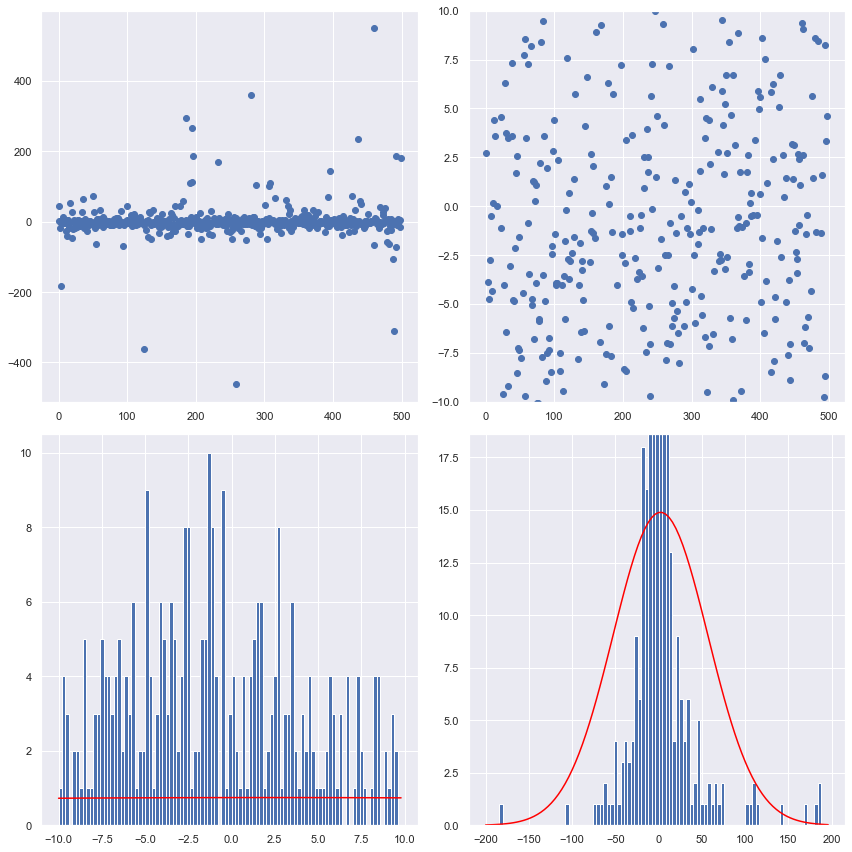

In [89]:
# Add code here to generate the dataset.  Start with 500 points.
# True location of the radioactive source
x0_true = -2.
y0_true = 7.

# Original x0_true and y0_true
# x0_true = 1.
# y0_true = 1.

# Generate num_pts random numbers distributed according to dist and plot 
num_pts = 500
x_pts = np.arange(num_pts)

# Distribution knowing where the source is: scipy.stats.cauchy(loc, scale)
dist = cauchy(x0_true, y0_true)
dist_pts = dist.rvs(num_pts)  

# Compute the mean and the variance of the sample.
mean = np.mean(dist_pts)
var = np.var(dist_pts)

# Make some plots!
fig = plt.figure(figsize=(12,12))

# First plot all the points, letting it autoscale the counts
ax_1 = fig.add_subplot(2,2,1)
ax_1.scatter(x_pts, dist_pts)  

# Repeat but zoom in to near the origin
ax_2 = fig.add_subplot(2,2,2)
ax_2.scatter(x_pts, dist_pts)
ax_2.set_ylim(-10.,10.)

# Make a zoomed-in histogram
ax_3 = fig.add_subplot(2,2,3)
out = ax_3.hist(dist_pts, bins=np.arange(-10., 10., 0.2))

# Add the Gaussian PDF with the same mean and variance to the histogram. 
# Note that we normalize the PDF to make the comparison convenient.
from scipy.stats import norm
ax_3.plot(np.arange(-10., 10., 0.2), 0.2*512*norm.pdf(np.arange(-10., 10., 0.2), mean,np.sqrt(var)), color='red')

# Finally make a zoomed-out histogram
ax_4 = fig.add_subplot(2,2,4)
out = ax_4.hist(dist_pts, bins=np.arange(-200., 200., 4))

# Add the Gaussian PDF with the same mean and variance to the histogram. 
# Note that we normalize the PDF to make the comparison convenient.
xlist = np.arange(-200., 200., 4)
ylist = 512*4*norm.pdf(np.arange(-200., 200., 4),mean,np.sqrt(var))
ax_4.plot(xlist, ylist, color='red')
ax_4.set_ylim(0,np.max(ylist)*1.25)

# Print out the numerical limits (max and min)
print('maximum = ', np.amax(dist_pts))
print('minimum = ', np.amin(dist_pts))

fig.tight_layout()

In the histograms, the red line is the PDF of the normal distribution with the same mean and variance as the simulated data. It is there to show the heavy-tailed nature of the Gaussian distribution.

## PDFs for applying Bayes' rule

*Adapt code from the two notebooks to express the logarithms of the prior, likelihood, and posterior for this case.*

In [42]:
# Add code for the log_prior, log_likelihood, and log_posterior
def log_prior(x0, y0, x_min=-5., x_max=+5., y_min = +0., y_max = +10.):
    """
    Log uniform prior from x_min to x_max and y_min to y_max.  Not normalized!
    """
    if (x0 > x_min) and (x0 < x_max) and (y0 > y_min) and (y0 < y_max):
        return 0.
    else:
        return -np.inf    # log(0) = -inf
    
def log_likelihood(x0, y0, dist_pts): 
    """
    Log likelihood for the data set given by the dist_pts array,
    assuming independent.  Not normalized!  
    """
    if y0 <= 0:
        return -np.inf
    else:
        L_pts = -np.log(y0**2 + (dist_pts - x0)**2) + np.log(y0)
        return np.sum(L_pts)

def log_posterior(pos, dist_pts, x_min=-5., x_max=+5., y_min = +0., y_max = +10.):
    """
    Calculate the posterior for a coordinates pair, pos = [x0, y0], 
    given a list of observations (dist_pts). 
    """    
    log_L_pts = log_likelihood(pos[0], pos[1], dist_pts)

    log_prior_pts = log_prior(pos[0], pos[1], x_min, x_max, y_min, y_max) 

    log_posterior_pts = log_prior_pts + log_L_pts
    return log_posterior_pts

These functions are taken from the original 1D radioactive lighthouse notebook. However, the log_likelihood function now already sums over all the data points in dist_pts, and the last function returns the logarithm of the posterior PDF, not the posterior PDF itself.

## Run MCMC

*Copy code to run `emcee` and make any necessary changes.*

In [92]:
# Add the code to run emcee
ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take

# Defining the min and max values of x and y
x_min = -5.
x_max = +5.
y_min = +0.
y_max = +10.
min_pos = np.array([x_min, y_min])
max_pos = np.array([x_max, y_max])

# we'll start at random locations within the prior volume
starting_guesses = min_pos + \
                   (max_pos - min_pos) * np.random.rand(nwalkers,ndim)

print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[dist_pts, x_min, x_max, y_min, y_max])

# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(pos, nsteps)

print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.719 (in total 50000 steps)


The only changes I made here compared to the Gaussian noise notebook are the parameters we are estimating (Now, they are of the form pos = (x0, y0).) and their allowed values ($-5\leq x_0\leq 5$ and $0\leq y_0\leq 10$).

## Generate figures

Note: you do not need to do the maximum likelihood estimates that were added to the corner plot for the Gaussian noise case.  You can skip that part of the code.

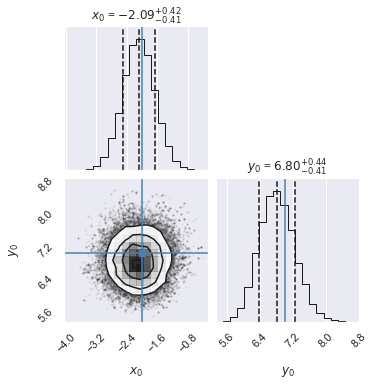

In [93]:
# Add the code to make a corner plot
# make a corner plot with the posterior distribution
fig = corner.corner(samples, labels=["$x_0$", "$y_0$"],
                    truths=[x0_true, y0_true],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

# First, extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

All frequentist-related lines are not displayed. The dashed lines in the histograms represent the 16-th, 50-th and 84-th percentiles of the empirical distribution, which would approximately correspond to $\mu-\sigma$, $\mu$ and $\mu+\sigma$ if the data exactly followed a normal distribution with mean $\mu$ and variance $\sigma^2$.

## Analysis

Summarize the results for the following investigations.  You can simply add to the cell containing the questions or else start new cells.

1. *Run the notebook 10 times (which will generate 10 different sets of random data).  Record the values of $x_0$ and $y_0$ and their uncertainties given on the corner plot for each run.  Is the actual spread of values consistent with the given uncertainties?* <br/>

In the table below, $(\delta x_0)^-$ is the lower uncertainty of $x_0$, and $(\delta x_0)^+$ is the upper uncertainty. The similar definitions apply to $(\delta y_0)^-$ and $(\delta y_0)^+$.

| Trial | $\langle x_0\rangle$ | $(\delta x_0)^-$ | $(\delta x_0)^+$ | $\left\langle y_0\right\rangle$ | $(\delta y_0)^-$ | $(\delta y_0)^+$ |  
| :-------------: | :----------: | :-----------: | :-----------: | :-------------: | :----------: | :-----------: | 
|  1           |   0.99     |    0.06    |    0.06   |   0.96     |    0.06    |    0.07   |
|  2           |   0.92     |    0.07    |    0.06   |   1.03     |    0.06    |    0.07   |
|  3           |   0.98     |    0.06    |    0.06   |   0.98     |    0.06    |    0.07   |
|  4           |   1.10     |    0.06    |    0.06   |   0.97     |    0.06    |    0.06   |
|  5           |   0.97     |    0.06    |    0.06   |   1.02     |    0.06    |    0.07   |
|  6           |   1.08     |    0.07    |    0.07   |   1.05     |    0.06    |    0.07   |
|  7           |   0.95     |    0.06    |    0.06   |   1.01     |    0.06    |    0.07   |
|  8           |   1.03     |    0.06    |    0.06   |   0.99     |    0.06    |    0.06   |
|  9           |   0.92     |    0.06    |    0.06   |   0.96     |    0.06    |    0.06   |
|  10          |   1.06     |    0.06    |    0.06   |   1.01     |    0.06    |    0.07   |

From the table, the sample standard deviation of $\left\langle x_0\right\rangle$'s is 0.0646, which is consistent with the uncertainties (between 0.06 and 0.07). For $\left\langle y_0\right\rangle$'s, the sample standard deviation is 0.0308, which is much lower than the given uncertainties. However, the discrepancy may still be within the realm of possibility.

2. *Increase the number of data points by a factor of 10.  By how much does the width of the posterior shrink?  Is this expected?* <br/>

We get $\left\langle x_0\right\rangle = 0.98 \pm 0.02$ and $\left\langle y_0\right\rangle = 1.01\pm 0.02$. The uncertainty of both parameter estimates in both directions is 0.02, which is close to $\frac{0.063}{\sqrt{10}}$. This is indicative of the possible trend that the uncertainty $\sim\frac{1}{\sqrt{N_{\text{sample}}}}$. According to our discussion of the 1D radioactive lighthouse problem, the decrease of uncertainty should be expected when the estimate is produced from the posterior distribution in the Bayesian framework, since the posterior distribution is updated in the way that accounts for the additional knowledge gain from each data point. Note that this would not be the case if we used the frequentist approach, as the underlying Gaussian distribution of each $x_k$ has no second moment and hence violates the central limit theorem. <br/>

3. *What does increasing the number of MC steps per walker do?* <br/>

Assuming that the increase applies only to nsteps (keeping the number of burning steps fixed), the resulting parameter estimates and their uncertainties remain similar in values. However, the code takes longer to run and the total steps in emcee's printout increases accordingly. In practice, increasing the number of steps essentially makes each walker perform more MCMC simulation steps on top of the initially assigned 1000 burning steps plus 1000 simulation steps. As long as we set aside enough burning steps, the walker's positions should already converge by the time the actual simulation starts, and hence increasing the number of simulation steps makes no significant change because the walker will basically repeat more of the same things. On the other hand, if not enough burning steps were assigned, increasing the number of simulation steps should reduce the uncertainties of parameter estimates. <br/>

4. *Try changing `x0_true` and `y0_true`.  Does it still work?* <br/>

Qualitatively, the program still works in the same way. However, larger values of `y0_true` leads to wider ranges of the detecting positions $x_k$. (Although the variance does not exist, one can compare, e.g. the interquartile range of the data) This leads to higher uncertainties in the prediction of $x_0$ and $y_0$. For example, the latest version displayed on the final output of this notebook shows the results for `x0_true` of $-2$ and `y0_true` of 7 using 500 data points. The uncertainties become close to 0.42, which is much larger than 0.06 we got when both `x0_true` and `y0_true` are 1. The value of `x0_true` has no effect on the quality of the estimate, as long as it stays inside the support of the prior distribution.  <br/>

In [45]:
# This is to display the table nicely for question 1.
%%html

<style> 
 table { width:80% !important; }
 table td, table th, table tr {border: 2px solid black !important; 
                               text-align:center !important;
                               font-size: 20px;}
</style>